# Libraries

In [1]:
# if you use google colab, install the following libraries:
#!pip install emoji datasets contractions pyLDAvis fasttext

In [3]:
import os
import re
import pickle
import string
from pprint import pprint
from math import sqrt, pow, exp

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset

import emoji
import contractions
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import pyLDAvis.gensim
import pyLDAvis

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import fasttext
from sklearn.manifold import TSNE

plt.style.use('seaborn-v0_8-pastel')

## Amazon US reviews

Amazon Customer Reviews (a.k.a. Product Reviews) is one of Amazons iconic products. In a period of over two decades since the first review in 1995, millions of Amazon customers have contributed over a hundred million reviews to express opinions and describe their experiences regarding products on the Amazon.com website. 

Each Dataset contains the following columns: 
- marketplace - 2 letter country code of the marketplace where the review was written. 
- customer_id - Random identifier that can be used to aggregate reviews written by a single author. 
- review_id - The unique ID of the review. 
- product_id - The unique Product ID the review pertains to. In the multilingual dataset the reviews for the same product in different countries can be grouped by the same product_id. 
- product_parent - Random identifier that can be used to aggregate reviews for the same product. 
- product_title - Title of the product. 
- product_category - Broad product category that can be used to group reviews (also used to group the dataset into coherent parts). 
- star_rating - The 1-5 star rating of the review. 
- helpful_votes - Number of helpful votes. total_votes - Number of total votes the review received. 
- vine - Review was written as part of the Vine program. 
- verified_purchase - The review is on a verified purchase. 
- review_headline - The title of the review. 
- review_body - The review text. 
- review_date - The date the review was written.

Visit this [site](https://huggingface.co/datasets/amazon_us_reviews) for more information.

# Introduction

We're going to build a exploratory data analysis (EDA) notebook. We'll explore different kind of aspects from the following questions:
- How big is this data set?
- What fields can we find here and what they mean?
- Does this data set contain duplicated data?
- What is the data distribution by field?
- Do these fields contain nulls? How can we treat them?
- Are these fields correlated? What decisions can we make based on this?

We might answer some or all of these questions, however we'll put more enphasis on text data. For text data, we can formulate the following questions:
- How big is it? How many documents and words do we have? What is the vocabulary size?
- How long are the documents?
- Are there any missings or empty texts?
- Are there any special character in the data or emoticons?
- Are there any spelling mistakes in the data?
- What are some common words or phrases in general or by any specific category or label?
- Are there any pre-defined categories or topics associated with the text data?
- Are there any trends or patterns over time?

We're also going to explore different kind of text representations and how they're visualized.

Finally, we're going to explore some topics found on the data.

# Load data set

In [2]:
english_dataset = load_dataset('amazon_us_reviews', 'Video_Games_v1_00')

Found cached dataset amazon_us_reviews (/home/rodrigo/.cache/huggingface/datasets/amazon_us_reviews/Video_Games_v1_00/0.1.0/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
# for this exercise we're going to select just a sample of the data
sample_size = 5_000
df = english_dataset['train'].to_pandas().sample(sample_size, random_state=18)
print(f"Sample size: {round(sample_size/english_dataset['train'].num_rows*100,2)}%")

Sample size: 0.28%


In [4]:
# save data for further analysis
df.to_parquet('../data/df_amazon_reviews_sample_5k.gzip', compression='gzip')

In [4]:
# load data
df = pd.read_parquet('../data/df_amazon_reviews_sample_5k.gzip')

# Exploratory data analysis

In [6]:
print(f'Number of documents in the dataset: {df.shape[0]}')
print(f'Number of fields in the dataset: {df.shape[1]}')

Number of documents in the dataset: 5000
Number of fields in the dataset: 15


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 1660627 to 991948
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   marketplace        5000 non-null   object
 1   customer_id        5000 non-null   object
 2   review_id          5000 non-null   object
 3   product_id         5000 non-null   object
 4   product_parent     5000 non-null   object
 5   product_title      5000 non-null   object
 6   product_category   5000 non-null   object
 7   star_rating        5000 non-null   int32 
 8   helpful_votes      5000 non-null   int32 
 9   total_votes        5000 non-null   int32 
 10  vine               5000 non-null   int64 
 11  verified_purchase  5000 non-null   int64 
 12  review_headline    5000 non-null   object
 13  review_body        5000 non-null   object
 14  review_date        5000 non-null   object
dtypes: int32(3), int64(2), object(10)
memory usage: 566.4+ KB


We notice from the feature report that some variables are binary like 'vine' and 'verified_purchase'.
No nulls detected in dataset

# Field analysis

In [8]:
# check empty review bodies
(df.review_body.str.len() == 0).value_counts()

review_body
False    5000
Name: count, dtype: int64

In [9]:
# check unique values
for field in df.columns:
    print(f"There are(is) {df[field].nunique():,} unique value(s) for {field}")

There are(is) 1 unique value(s) for marketplace
There are(is) 4,957 unique value(s) for customer_id
There are(is) 5,000 unique value(s) for review_id
There are(is) 3,591 unique value(s) for product_id
There are(is) 3,528 unique value(s) for product_parent
There are(is) 3,115 unique value(s) for product_title
There are(is) 1 unique value(s) for product_category
There are(is) 5 unique value(s) for star_rating
There are(is) 63 unique value(s) for helpful_votes
There are(is) 86 unique value(s) for total_votes
There are(is) 2 unique value(s) for vine
There are(is) 2 unique value(s) for verified_purchase
There are(is) 3,927 unique value(s) for review_headline
There are(is) 4,896 unique value(s) for review_body
There are(is) 2,451 unique value(s) for review_date


In [10]:
# check features with few unique values
print(f"Unique values in market place are: {df['marketplace'].unique()}")
print(f"Unique values in product category are: {df['product_category'].unique()}")
print(f"Unique values in star rating are: {sorted(df['star_rating'].unique())}")
print(f"Unique values in vine are: {sorted(df['vine'].unique())}")
print(f"Unique values in verified purchase are: {sorted(df['verified_purchase'].unique())}")

Unique values in market place are: ['US']
Unique values in product category are: ['Video Games']
Unique values in star rating are: [1, 2, 3, 4, 5]
Unique values in vine are: [0, 1]
Unique values in verified purchase are: [0, 1]


We'll remove market place and product category when creating the ML feature data set. This situation is obvious since we have selected US amazon reviews and just for the video game product category. Vine and verified_purchase are expected to be binary because of the variable definition

## Analyze customers

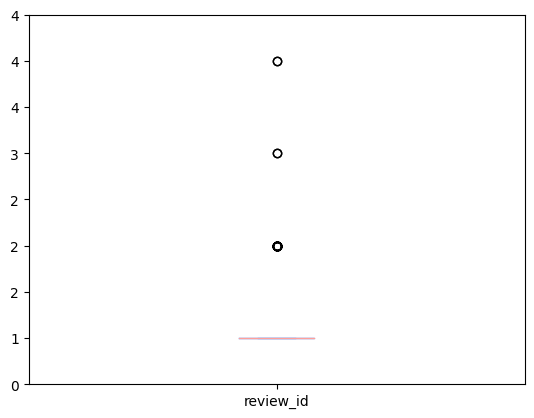

In [11]:
# reviews by customer
df.groupby('customer_id')['review_id'].count().plot(kind='box')
plt.gca().set_yticks(plt.gca().get_yticks())
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()]);

In [12]:
df.groupby('customer_id')['review_id'].count().describe(percentiles=[.25,.5,.75,.9,.95,.99]).apply(lambda x: f"{x:,.3f}")

count    4,957.000
mean         1.009
std          0.109
min          1.000
25%          1.000
50%          1.000
75%          1.000
90%          1.000
95%          1.000
99%          1.000
max          4.000
Name: review_id, dtype: object

Up 99% of customers made up to 1 review in this sample

In [13]:
# sample of reviews done by the customer with highest number of reviews
customers = df.groupby('customer_id')['review_id'].count()
outlier = customers[customers == 4].index[0]
df[df.customer_id == outlier].sample(3, random_state=18)[['review_id','customer_id','review_headline','review_body','review_date']]

,review_id,customer_id,review_headline,review_body,review_date
1134160,R10IZVZV1GK75D,40955995,A very unique puzzle game,"The Good: Innovative gameplay, great graphics ...",2012-03-29
1133982,R3H90SO0ON6P2N,40955995,A very dark and sadistic game,"The Good: Creepy unsettling atmosphere, grueso...",2012-03-29
1134601,R1U54UKO36ERYU,40955995,The lack of a simulation mode makes the game b...,"The Good: Superb visuals, lots of tracks and c...",2012-03-28


## Analyze products

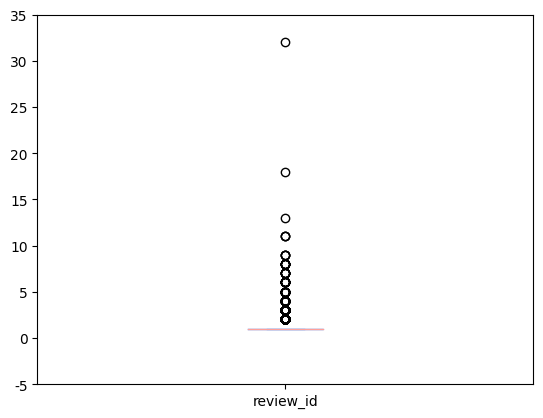

In [14]:
# check amount of reviews by product
df.groupby('product_id')['review_id'].count().plot(kind='box')
plt.gca().set_yticks(plt.gca().get_yticks())
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()]);

In [15]:
df.groupby('product_id')['review_id'].count().describe(percentiles=[.25,.5,.75,.9,.95,.99]).apply(lambda x: f"{x:,.3f}")

count    3,591.000
mean         1.392
std          1.147
min          1.000
25%          1.000
50%          1.000
75%          1.000
90%          2.000
95%          3.000
99%          6.000
max         32.000
Name: review_id, dtype: object

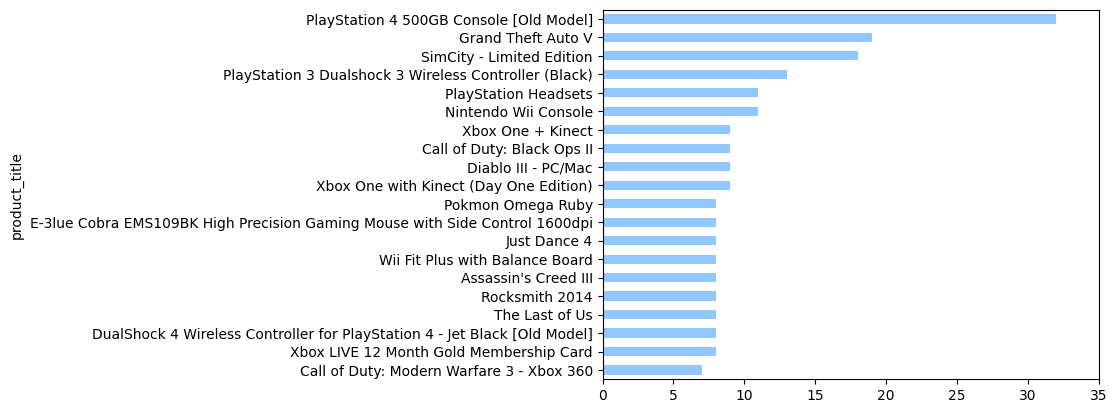

In [16]:
# sample of reviews done by the customer with highest number of reviews
products = df.groupby('product_id')['review_id'].count()
outliers = products[products >= 6].index.values
df[df.product_id.isin(outliers)].product_title.value_counts().sort_values(ascending=True).tail(20).plot(kind='barh')
plt.gca().set_xticks(plt.gca().get_xticks())
plt.gca().set_xticklabels([f'{x:,.0f}' for x in plt.gca().get_xticks()]);

Most of the reviews have been done to the PS4 then GTA V and so on. That shows the popularity of those game products.

## Analyze star rating

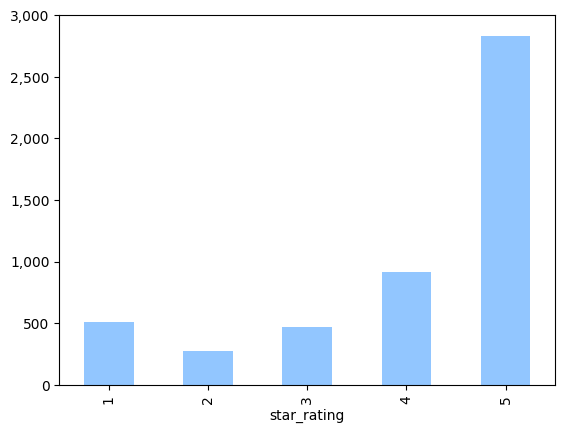

In [17]:
# check number of reviews for star rating
df.groupby('star_rating')['review_id'].count().plot(kind='bar')
plt.gca().set_yticks(plt.gca().get_yticks())
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()]);

There's a clear evidence that there's a big number of videogames that are great games. If we'd like to classify texts using this field as label, we'd need to be careful with unbalance.

## Analyze verified purchase

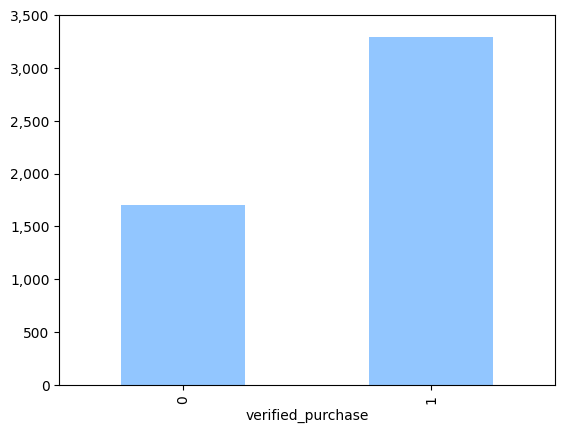

In [18]:
# check reviews by verified purchase

df.groupby('verified_purchase')['review_id'].count().plot(kind='bar')
plt.gca().set_yticks(plt.gca().get_yticks())
plt.gca().set_yticklabels(f'{x:,.0f}' for x in plt.gca().get_yticks());

We can see that almost 50% of the reviews in this sample come from not verified purchases.

## Analyze helpfull votes

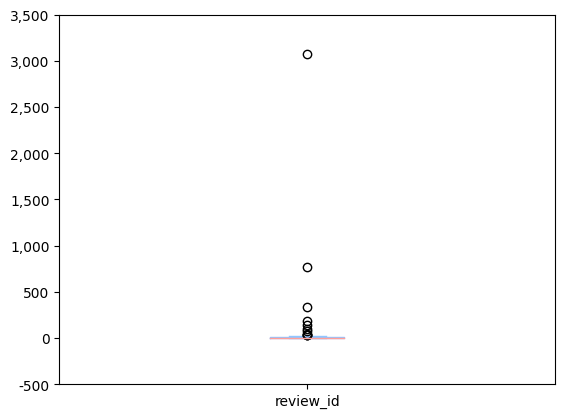

In [5]:
# check amount of reviews by helpful votes

df.groupby('helpful_votes')['review_id'].count().plot(kind='box')
plt.gca().set_yticks(plt.gca().get_yticks())
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()]);

In [6]:
df.groupby('helpful_votes')['review_id'].count().describe(percentiles=[.25,.5,.75,.9,.95,.99]).apply(lambda x: f"{x:,.3f}")

count       63.000
mean        79.365
std        397.480
min          1.000
25%          1.000
50%          3.000
75%          9.500
90%         68.400
95%        182.400
99%      1,642.620
max      3,068.000
Name: review_id, dtype: object

Up to 75 % of the votes have up to ~9 reviews. There are some vote quantities that are outliers based on these reports

In [7]:
# show what vote amounts have the highest amount of reviews
votes = df.groupby('helpful_votes')['review_id'].count()
votes[votes > 60]

helpful_votes
0    3068
1     769
2     335
3     187
4     141
5      94
6      74
Name: review_id, dtype: int64

## Analyze reviews through time

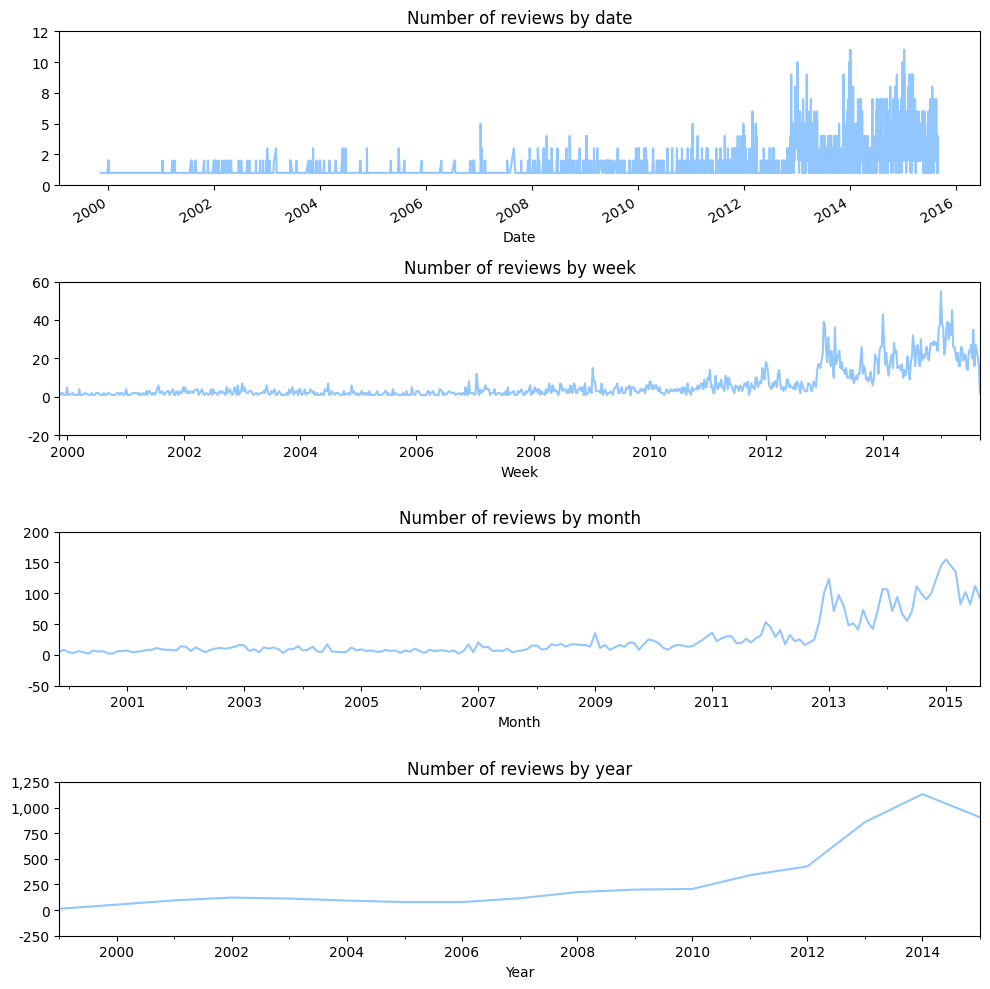

In [21]:
# check amount of reviews by date dimension
df['review_date'] = df.review_date.astype('datetime64[ns]')
df['review_week'] = df.review_date.dt.to_period('W')
df['review_month'] = df.review_date.dt.to_period('M')
df['review_year'] = df.review_date.dt.to_period('Y')

fig, axs = plt.subplots(4,1)
date_columns = ['review_date', 'review_week', 'review_month', 'review_year']
for i, column in enumerate(date_columns):
    df.groupby(column)['review_id'].count().plot(kind='line',figsize=(10,10), ax=axs[i])
    axs[i].set_xlabel(f"{(column.split('_')[1]).capitalize()}")
    axs[i].set_yticks(axs[i].get_yticks())
    axs[i].set_yticklabels(f'{x:,.0f}' for x in axs[i].get_yticks())
    axs[i].set_title(f"Number of reviews by {column.split('_')[1]}")
plt.tight_layout();

We can see a positive trend when analyzing the data by year. Also, there's evidence of seasonality specially since 2013 when analyzing the data monthly. That happens because of the high amount of reviews by the end/start of the year and a lower peak in the middle of the year, both repeat in a positive trend yearly.

## Explore text fields

### Word size distribution

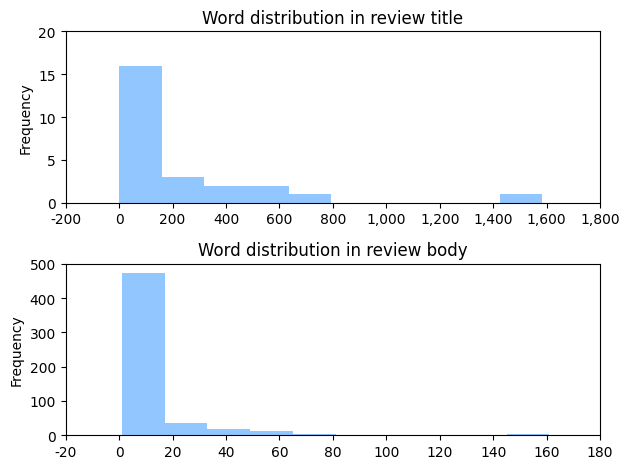

In [22]:
# get the word size per document and show the distribution

fig, axs = plt.subplots(2,1)

df['review_headline'].apply(lambda x: len(x.split())).value_counts().plot(kind='hist', ax=axs[0])
df['review_body'].apply(lambda x: len(x.split())).value_counts().plot(kind='hist', ax=axs[1])

axs[0].set_title('Word distribution in review title')
axs[1].set_title('Word distribution in review body')

for ax in axs:
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(f'{x:,.0f}' for x in ax.get_yticks())
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(f'{x:,.0f}' for x in ax.get_xticks())
fig.tight_layout();

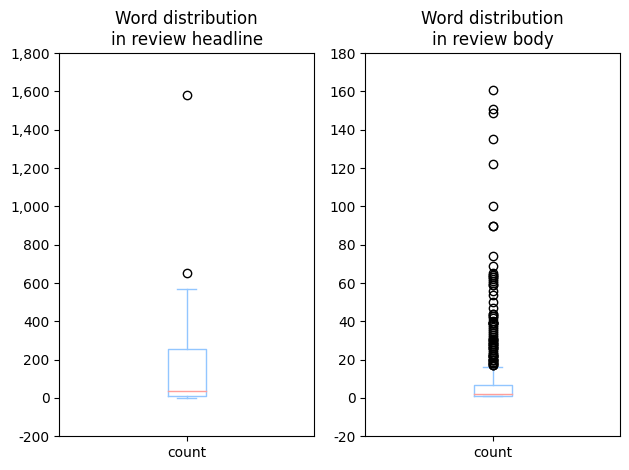

In [23]:
# show also the box plot
fig, axs = plt.subplots(1,2)

df['review_headline'].apply(lambda x: len(x.split())).value_counts().plot(kind='box', ax=axs[0])
df['review_body'].apply(lambda x: len(x.split())).value_counts().plot(kind='box', ax=axs[1])

axs[0].set_title('Word distribution\nin review headline')
axs[1].set_title('Word distribution\nin review body')

for ax in axs:
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(f'{x:,.0f}' for x in ax.get_yticks())
plt.tight_layout()

In [24]:
pd.DataFrame({'word_stats_headline': df['review_headline'].apply(lambda x: len(x.split())).describe(),
            'word_stats_body': df['review_body'].apply(lambda x: len(x.split())).describe()
            }).style.format('{:,.2f}')

,word_stats_headline,word_stats_body
count,"5,000.00","5,000.00"
mean,4.26,100.28
std,3.25,200.89
min,1.00,1.00
25%,2.00,21.00
50%,3.00,39.00
75%,6.00,97.00
max,29.00,"3,062.00"


Focusing on the review bodies, in average there are ~100 words per review, median is 39 words per review, and the maximum is 3k words.

### Emoticon analysis

In [25]:
# example of how use 'emoji' library
text_example = 'my opinion: 😄 Positive on this..., but 😭 Negative on this ... 👍'

# list emojis in text
emoji.emoji_list(text_example)

[{'match_start': 12, 'match_end': 13, 'emoji': '😄'},
 {'match_start': 39, 'match_end': 40, 'emoji': '😭'},
 {'match_start': 62, 'match_end': 63, 'emoji': '👍'}]

In [26]:
# 'demojize' text
print(emoji.demojize(text_example))

my opinion: :grinning_face_with_smiling_eyes: Positive on this..., but :loudly_crying_face: Negative on this ... :thumbs_up:


  0%|          | 0/5000 [00:00<?, ?it/s]

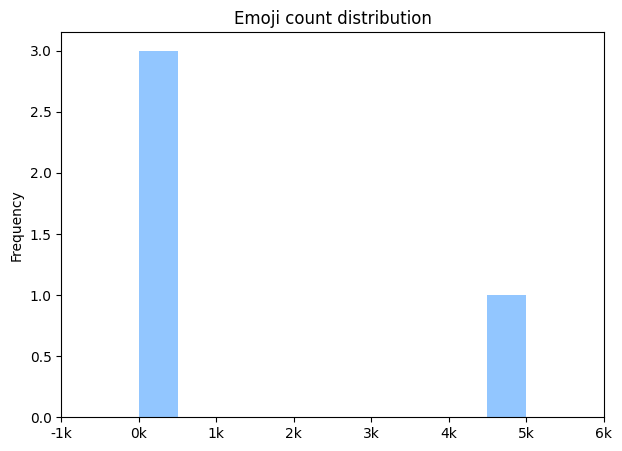

In [9]:
# count the amount of emojis in each document and plot distribution

emojis = df.review_body.progress_apply(lambda x: len(emoji.emoji_list(x)))
emojis.value_counts().plot(kind='hist', figsize=(7,5))
plt.gca().set_xticks(plt.gca().get_xticks())
plt.gca().set_xticklabels([f'{round(x/1000,2):,.0f}k' for x in plt.gca().get_xticks()])
plt.title('Emoji count distribution');

In [10]:
# emoji stats
emojis.value_counts().describe(percentiles=[.25,.5,.75,.9,.95,.99]).apply(lambda x: f'{x:,.2f}')

count        4.00
mean     1,250.00
std      2,494.00
min          1.00
25%          1.00
50%          4.00
75%      1,253.00
90%      3,495.80
95%      4,243.40
99%      4,841.48
max      4,991.00
Name: count, dtype: object

In [18]:
# show what emoji amounts have the highest review quantity
emojis.value_counts()

review_body
0    4991
1       7
2       1
7       1
Name: count, dtype: int64

In [20]:
# check the top reviews with the highest emoji counts
with pd.option_context('display.max_colwidth', None):
    display(df[df.index.isin(emojis.sort_values(ascending=False).head(1).index)][['review_id','product_title','star_rating','review_headline','review_body','review_date']])

,review_id,product_title,star_rating,review_headline,review_body,review_date
180063,R16UMWJYWWJCE6,Rayman Origins,5,Five Stars,I purchased this game for my baby 👶 boy and he plays it all day 👍👍👍👍👍👍,2015-03-28


### Special character analysis

In [30]:
# count special characters being used by document. Common special characters are not being considered as "special"

special_characters = df.review_body.progress_apply(lambda x: re.sub(r"[a-zA-Z0-9 ,.\-:\?\!()']",'',x))

  0%|          | 0/5000 [00:00<?, ?it/s]

In [31]:
# show some special characters found
special_characters_exploded = special_characters.apply(lambda x: np.unique([w.strip() for w in x])).explode()
special_characters_exploded[~special_characters_exploded.isnull()].unique()[:100]

array(['"', '/', '<', '>', '\\', '&', '%', ';', '~', '$', '@', '+', '#',
       '*', 'Ñ', '[', ']', '=', '_', '\x1a', '\ufeff', '®', '`', '…', '👏',
       'à', 'é', 'ñ', '—', '’', '´', '（', '“', '”', '！', 'á', '☺', '😉',
       '{', '}', '^', 'í', 'ú', '¡', '😄', '😡', '½', 'ó', '😕', '👍', '👶'],
      dtype=object)

### Word cloud 

/home/rodrigo/anaconda3/envs/py3108/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


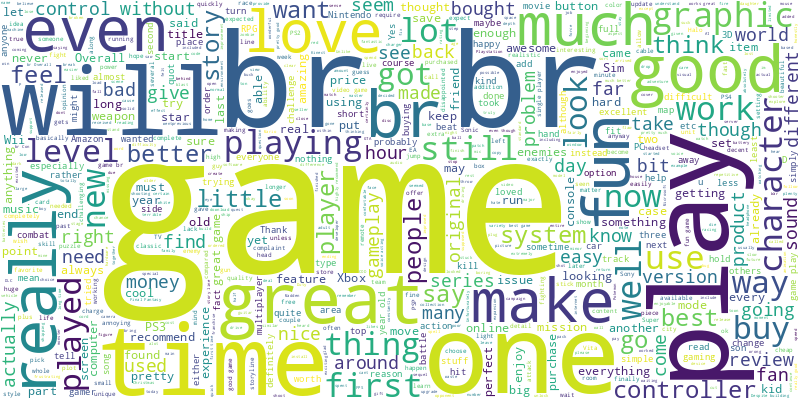

In [32]:
# Join the different processed titles together.
long_string = ','.join(df['review_body'].values)

# Create the WordCloud
wordcloud = WordCloud(background_color='white', max_words=5000, contour_width=3, contour_color='steelblue', width=800, height=400)
wordcloud.generate(long_string)
wordcloud.to_image()

From the wordcloud, we can see expected words to appear like game, play, etc. What is not expected is finding words like br. This is a candidate to be a stop word.

# Text representation

## Pre-processing

In [30]:
# util function
def show_transformation(df, seed=18):
    with pd.option_context('display.max_colwidth', None):
        display(df[['review_body','review_body_preprocessed']].sample(1, random_state=seed))

In [31]:
# expand contractions
df['review_body_preprocessed']=df['review_body'].progress_apply(lambda x: contractions.fix(x))
show_transformation(df)

  0%|          | 0/5000 [00:00<?, ?it/s]

,review_body,review_body_preprocessed
1736702,"I just finished this game after a long time playing it. I haven't really played any RPG's before, but I had heard good things about this game, and it was at a bargain price, so I said &quot;what the heck.&quot;<br />What a lucky, lucky man I am. This game is simply marvelous. The writing (both storyline and dialogue) is simply outstanding. You really start to care for your character (the Nameless One) and his companions. You almost feel his pain when he gets hit, and you can certainly sympathise with his frustration as his past eludes him., yet feel his determination to find out what he's missing.<br />The companions are more than one-note characters. They are almost three-dimensional, with pasts, motives that may differ from yours and things that they may be keeping from you. They are all related to you in some way, and it's really fascinating to watch the story unfold.<br />The graphics are suitably dark to fit the tone of the game, yet they are very well rendered. You can almost feel the heat of the Outlands and Baator. The city that you start in, Sigil, is almost claustrophobic (and yes, that's intentional). Everything works.<br />I can't think of a single thing that annoyed me in this game. Maybe the pathfinding at times, but that's easily fixed by not clicking on a space too far ahead of the party to get them to go there. You can't expect them to find their own way back in a cavern where there's lots of tunnels. I did that once on accident, and they decided to go through the territory I was retreating from to get where I was telling them to go. Needless to say, I reloaded a save game there. :-)<br />Anyway, buy this game if you have any interest in FRPG's. You don't even have the money excuse, because it's so cheap. Buy it. Play it. And then realize that, as good as some of the other games you're playing are, there is something that tops even those.","I just finished this game after a long time playing it. I have not really played any RPG's before, but I had heard good things about this game, and it was at a bargain price, so I said &quot;what the heck.&quot;<br />What a lucky, lucky man I am. This game is simply marvelous. The writing (both storyline and dialogue) is simply outstanding. You really start to care for your character (the Nameless One) and his companions. You almost feel his pain when he gets hit, and you can certainly sympathise with his frustration as his past eludes him., yet feel his determination to find out what he is missing.<br />The companions are more than one-note characters. They are almost three-dimensional, with pasts, motives that may differ from yours and things that they may be keeping from you. They are all related to you in some way, and it is really fascinating to watch the story unfold.<br />The graphics are suitably dark to fit the tone of the game, yet they are very well rendered. You can almost feel the heat of the Outlands and Baator. The city that you start in, Sigil, is almost claustrophobic (and yes, that is intentional). Everything works.<br />I cannot think of a single thing that annoyed me in this game. Maybe the pathfinding at times, but that is easily fixed by not clicking on a space too far ahead of the party to get them to go there. You cannot expect them to find their own way back in a cavern where there is lots of tunnels. I did that once on accident, and they decided to go through the territory I was retreating from to get where I was telling them to go. Needless to say, I reloaded a save game there. :-)<br />Anyway, buy this game if you have any interest in FRPG's. You do not even have the money excuse, because it is so cheap. Buy it. Play it. And then realize that, as good as some of the other games you are playing are, there is something that tops even those."


In [32]:
# demojize texts
df['review_body_preprocessed']=df['review_body_preprocessed'].progress_apply(lambda x: emoji.demojize(x))
# look at a previous example
with pd.option_context('display.max_colwidth', None):
    display(df[df.index == 180063][['review_body','review_body_preprocessed']])

  0%|          | 0/5000 [00:00<?, ?it/s]

,review_body,review_body_preprocessed
180063,I purchased this game for my baby 👶 boy and he plays it all day 👍👍👍👍👍👍,I purchased this game for my baby :baby: boy and he plays it all day :thumbs_up::thumbs_up::thumbs_up::thumbs_up::thumbs_up::thumbs_up:


In [33]:
# remove punctuation
string.punctuation
print(f'Punctuation list: {string.punctuation}')

def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

df['review_body_preprocessed']=df['review_body_preprocessed'].progress_apply(lambda x: remove_punctuation(x))
show_transformation(df)

Punctuation list: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


  0%|          | 0/5000 [00:00<?, ?it/s]

,review_body,review_body_preprocessed
1736702,"I just finished this game after a long time playing it. I haven't really played any RPG's before, but I had heard good things about this game, and it was at a bargain price, so I said &quot;what the heck.&quot;<br />What a lucky, lucky man I am. This game is simply marvelous. The writing (both storyline and dialogue) is simply outstanding. You really start to care for your character (the Nameless One) and his companions. You almost feel his pain when he gets hit, and you can certainly sympathise with his frustration as his past eludes him., yet feel his determination to find out what he's missing.<br />The companions are more than one-note characters. They are almost three-dimensional, with pasts, motives that may differ from yours and things that they may be keeping from you. They are all related to you in some way, and it's really fascinating to watch the story unfold.<br />The graphics are suitably dark to fit the tone of the game, yet they are very well rendered. You can almost feel the heat of the Outlands and Baator. The city that you start in, Sigil, is almost claustrophobic (and yes, that's intentional). Everything works.<br />I can't think of a single thing that annoyed me in this game. Maybe the pathfinding at times, but that's easily fixed by not clicking on a space too far ahead of the party to get them to go there. You can't expect them to find their own way back in a cavern where there's lots of tunnels. I did that once on accident, and they decided to go through the territory I was retreating from to get where I was telling them to go. Needless to say, I reloaded a save game there. :-)<br />Anyway, buy this game if you have any interest in FRPG's. You don't even have the money excuse, because it's so cheap. Buy it. Play it. And then realize that, as good as some of the other games you're playing are, there is something that tops even those.",I just finished this game after a long time playing it I have not really played any RPGs before but I had heard good things about this game and it was at a bargain price so I said quotwhat the heckquotbr What a lucky lucky man I am This game is simply marvelous The writing both storyline and dialogue is simply outstanding You really start to care for your character the Nameless One and his companions You almost feel his pain when he gets hit and you can certainly sympathise with his frustration as his past eludes him yet feel his determination to find out what he is missingbr The companions are more than onenote characters They are almost threedimensional with pasts motives that may differ from yours and things that they may be keeping from you They are all related to you in some way and it is really fascinating to watch the story unfoldbr The graphics are suitably dark to fit the tone of the game yet they are very well rendered You can almost feel the heat of the Outlands and Baator The city that you start in Sigil is almost claustrophobic and yes that is intentional Everything worksbr I cannot think of a single thing that annoyed me in this game Maybe the pathfinding at times but that is easily fixed by not clicking on a space too far ahead of the party to get them to go there You cannot expect them to find their own way back in a cavern where there is lots of tunnels I did that once on accident and they decided to go through the territory I was retreating from to get where I was telling them to go Needless to say I reloaded a save game there br Anyway buy this game if you have any interest in FRPGs You do not even have the money excuse because it is so cheap Buy it Play it And then realize that as good as some of the other games you are playing are there is something that tops even those


In [34]:
# keep alphabet chars only
def keep_alphabet_chars(text):
    return re.sub(r'[^a-zA-Z ]','',text)

df['review_body_preprocessed']=df['review_body_preprocessed'].progress_apply(lambda x: keep_alphabet_chars(x))
show_transformation(df)

  0%|          | 0/5000 [00:00<?, ?it/s]

,review_body,review_body_preprocessed
1736702,"I just finished this game after a long time playing it. I haven't really played any RPG's before, but I had heard good things about this game, and it was at a bargain price, so I said &quot;what the heck.&quot;<br />What a lucky, lucky man I am. This game is simply marvelous. The writing (both storyline and dialogue) is simply outstanding. You really start to care for your character (the Nameless One) and his companions. You almost feel his pain when he gets hit, and you can certainly sympathise with his frustration as his past eludes him., yet feel his determination to find out what he's missing.<br />The companions are more than one-note characters. They are almost three-dimensional, with pasts, motives that may differ from yours and things that they may be keeping from you. They are all related to you in some way, and it's really fascinating to watch the story unfold.<br />The graphics are suitably dark to fit the tone of the game, yet they are very well rendered. You can almost feel the heat of the Outlands and Baator. The city that you start in, Sigil, is almost claustrophobic (and yes, that's intentional). Everything works.<br />I can't think of a single thing that annoyed me in this game. Maybe the pathfinding at times, but that's easily fixed by not clicking on a space too far ahead of the party to get them to go there. You can't expect them to find their own way back in a cavern where there's lots of tunnels. I did that once on accident, and they decided to go through the territory I was retreating from to get where I was telling them to go. Needless to say, I reloaded a save game there. :-)<br />Anyway, buy this game if you have any interest in FRPG's. You don't even have the money excuse, because it's so cheap. Buy it. Play it. And then realize that, as good as some of the other games you're playing are, there is something that tops even those.",I just finished this game after a long time playing it I have not really played any RPGs before but I had heard good things about this game and it was at a bargain price so I said quotwhat the heckquotbr What a lucky lucky man I am This game is simply marvelous The writing both storyline and dialogue is simply outstanding You really start to care for your character the Nameless One and his companions You almost feel his pain when he gets hit and you can certainly sympathise with his frustration as his past eludes him yet feel his determination to find out what he is missingbr The companions are more than onenote characters They are almost threedimensional with pasts motives that may differ from yours and things that they may be keeping from you They are all related to you in some way and it is really fascinating to watch the story unfoldbr The graphics are suitably dark to fit the tone of the game yet they are very well rendered You can almost feel the heat of the Outlands and Baator The city that you start in Sigil is almost claustrophobic and yes that is intentional Everything worksbr I cannot think of a single thing that annoyed me in this game Maybe the pathfinding at times but that is easily fixed by not clicking on a space too far ahead of the party to get them to go there You cannot expect them to find their own way back in a cavern where there is lots of tunnels I did that once on accident and they decided to go through the territory I was retreating from to get where I was telling them to go Needless to say I reloaded a save game there br Anyway buy this game if you have any interest in FRPGs You do not even have the money excuse because it is so cheap Buy it Play it And then realize that as good as some of the other games you are playing are there is something that tops even those


In [35]:
# lower casing
df['review_body_preprocessed']=df['review_body_preprocessed'].str.lower()
show_transformation(df)

,review_body,review_body_preprocessed
1736702,"I just finished this game after a long time playing it. I haven't really played any RPG's before, but I had heard good things about this game, and it was at a bargain price, so I said &quot;what the heck.&quot;<br />What a lucky, lucky man I am. This game is simply marvelous. The writing (both storyline and dialogue) is simply outstanding. You really start to care for your character (the Nameless One) and his companions. You almost feel his pain when he gets hit, and you can certainly sympathise with his frustration as his past eludes him., yet feel his determination to find out what he's missing.<br />The companions are more than one-note characters. They are almost three-dimensional, with pasts, motives that may differ from yours and things that they may be keeping from you. They are all related to you in some way, and it's really fascinating to watch the story unfold.<br />The graphics are suitably dark to fit the tone of the game, yet they are very well rendered. You can almost feel the heat of the Outlands and Baator. The city that you start in, Sigil, is almost claustrophobic (and yes, that's intentional). Everything works.<br />I can't think of a single thing that annoyed me in this game. Maybe the pathfinding at times, but that's easily fixed by not clicking on a space too far ahead of the party to get them to go there. You can't expect them to find their own way back in a cavern where there's lots of tunnels. I did that once on accident, and they decided to go through the territory I was retreating from to get where I was telling them to go. Needless to say, I reloaded a save game there. :-)<br />Anyway, buy this game if you have any interest in FRPG's. You don't even have the money excuse, because it's so cheap. Buy it. Play it. And then realize that, as good as some of the other games you're playing are, there is something that tops even those.",i just finished this game after a long time playing it i have not really played any rpgs before but i had heard good things about this game and it was at a bargain price so i said quotwhat the heckquotbr what a lucky lucky man i am this game is simply marvelous the writing both storyline and dialogue is simply outstanding you really start to care for your character the nameless one and his companions you almost feel his pain when he gets hit and you can certainly sympathise with his frustration as his past eludes him yet feel his determination to find out what he is missingbr the companions are more than onenote characters they are almost threedimensional with pasts motives that may differ from yours and things that they may be keeping from you they are all related to you in some way and it is really fascinating to watch the story unfoldbr the graphics are suitably dark to fit the tone of the game yet they are very well rendered you can almost feel the heat of the outlands and baator the city that you start in sigil is almost claustrophobic and yes that is intentional everything worksbr i cannot think of a single thing that annoyed me in this game maybe the pathfinding at times but that is easily fixed by not clicking on a space too far ahead of the party to get them to go there you cannot expect them to find their own way back in a cavern where there is lots of tunnels i did that once on accident and they decided to go through the territory i was retreating from to get where i was telling them to go needless to say i reloaded a save game there br anyway buy this game if you have any interest in frpgs you do not even have the money excuse because it is so cheap buy it play it and then realize that as good as some of the other games you are playing are there is something that tops even those


In [36]:
# remove stop words
nltk.download('stopwords')
en_stopwords = stopwords.words('english') + ['br','one']

def remove_stopwords(text, en_stopwords):
    result = []
    for token in text.split():
        if token not in en_stopwords:
            result.append(token)
    return ' '.join(result)

df['review_body_preprocessed']=df['review_body_preprocessed'].progress_apply(lambda x: remove_stopwords(x, en_stopwords))
show_transformation(df)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rodrigo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  0%|          | 0/5000 [00:00<?, ?it/s]

,review_body,review_body_preprocessed
1736702,"I just finished this game after a long time playing it. I haven't really played any RPG's before, but I had heard good things about this game, and it was at a bargain price, so I said &quot;what the heck.&quot;<br />What a lucky, lucky man I am. This game is simply marvelous. The writing (both storyline and dialogue) is simply outstanding. You really start to care for your character (the Nameless One) and his companions. You almost feel his pain when he gets hit, and you can certainly sympathise with his frustration as his past eludes him., yet feel his determination to find out what he's missing.<br />The companions are more than one-note characters. They are almost three-dimensional, with pasts, motives that may differ from yours and things that they may be keeping from you. They are all related to you in some way, and it's really fascinating to watch the story unfold.<br />The graphics are suitably dark to fit the tone of the game, yet they are very well rendered. You can almost feel the heat of the Outlands and Baator. The city that you start in, Sigil, is almost claustrophobic (and yes, that's intentional). Everything works.<br />I can't think of a single thing that annoyed me in this game. Maybe the pathfinding at times, but that's easily fixed by not clicking on a space too far ahead of the party to get them to go there. You can't expect them to find their own way back in a cavern where there's lots of tunnels. I did that once on accident, and they decided to go through the territory I was retreating from to get where I was telling them to go. Needless to say, I reloaded a save game there. :-)<br />Anyway, buy this game if you have any interest in FRPG's. You don't even have the money excuse, because it's so cheap. Buy it. Play it. And then realize that, as good as some of the other games you're playing are, there is something that tops even those.",finished game long time playing really played rpgs heard good things game bargain price said quotwhat heckquotbr lucky lucky man game simply marvelous writing storyline dialogue simply outstanding really start care character nameless companions almost feel pain gets hit certainly sympathise frustration past eludes yet feel determination find missingbr companions onenote characters almost threedimensional pasts motives may differ things may keeping related way really fascinating watch story unfoldbr graphics suitably dark fit tone game yet well rendered almost feel heat outlands baator city start sigil almost claustrophobic yes intentional everything worksbr cannot think single thing annoyed game maybe pathfinding times easily fixed clicking space far ahead party get go cannot expect find way back cavern lots tunnels accident decided go territory retreating get telling go needless say reloaded save game anyway buy game interest frpgs even money excuse cheap buy play realize good games playing something tops even


In [37]:
# lemmatize words
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def lemmatize(text, lemmatizer):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text.split()]
    return ' '.join(lemmatized_words)

df['review_body_preprocessed']=df['review_body_preprocessed'].progress_apply(lambda x: lemmatize(x, lemmatizer))
show_transformation(df)

[nltk_data] Downloading package wordnet to /home/rodrigo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


  0%|          | 0/5000 [00:00<?, ?it/s]

,review_body,review_body_preprocessed
1736702,"I just finished this game after a long time playing it. I haven't really played any RPG's before, but I had heard good things about this game, and it was at a bargain price, so I said &quot;what the heck.&quot;<br />What a lucky, lucky man I am. This game is simply marvelous. The writing (both storyline and dialogue) is simply outstanding. You really start to care for your character (the Nameless One) and his companions. You almost feel his pain when he gets hit, and you can certainly sympathise with his frustration as his past eludes him., yet feel his determination to find out what he's missing.<br />The companions are more than one-note characters. They are almost three-dimensional, with pasts, motives that may differ from yours and things that they may be keeping from you. They are all related to you in some way, and it's really fascinating to watch the story unfold.<br />The graphics are suitably dark to fit the tone of the game, yet they are very well rendered. You can almost feel the heat of the Outlands and Baator. The city that you start in, Sigil, is almost claustrophobic (and yes, that's intentional). Everything works.<br />I can't think of a single thing that annoyed me in this game. Maybe the pathfinding at times, but that's easily fixed by not clicking on a space too far ahead of the party to get them to go there. You can't expect them to find their own way back in a cavern where there's lots of tunnels. I did that once on accident, and they decided to go through the territory I was retreating from to get where I was telling them to go. Needless to say, I reloaded a save game there. :-)<br />Anyway, buy this game if you have any interest in FRPG's. You don't even have the money excuse, because it's so cheap. Buy it. Play it. And then realize that, as good as some of the other games you're playing are, there is something that tops even those.",finished game long time playing really played rpgs heard good thing game bargain price said quotwhat heckquotbr lucky lucky man game simply marvelous writing storyline dialogue simply outstanding really start care character nameless companion almost feel pain get hit certainly sympathise frustration past eludes yet feel determination find missingbr companion onenote character almost threedimensional past motif may differ thing may keeping related way really fascinating watch story unfoldbr graphic suitably dark fit tone game yet well rendered almost feel heat outlands baator city start sigil almost claustrophobic yes intentional everything worksbr cannot think single thing annoyed game maybe pathfinding time easily fixed clicking space far ahead party get go cannot expect find way back cavern lot tunnel accident decided go territory retreating get telling go needle say reloaded save game anyway buy game interest frpgs even money excuse cheap buy play realize good game playing something top even


In [38]:
# stemming words
from  nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stemming(text, stemmer):
    stem = [stemmer.stem(word) for word in text.split()]
    return ' '.join(stem)

df['review_body_preprocessed_stem']=df['review_body_preprocessed'].progress_apply(lambda x: stemming(x, stemmer))
# compare lemmatization and stemming
with pd.option_context('display.max_colwidth', None):
    display(df[['review_body','review_body_preprocessed','review_body_preprocessed_stem']].sample(1, random_state=18))

  0%|          | 0/5000 [00:00<?, ?it/s]

,review_body,review_body_preprocessed,review_body_preprocessed_stem
1736702,"I just finished this game after a long time playing it. I haven't really played any RPG's before, but I had heard good things about this game, and it was at a bargain price, so I said &quot;what the heck.&quot;<br />What a lucky, lucky man I am. This game is simply marvelous. The writing (both storyline and dialogue) is simply outstanding. You really start to care for your character (the Nameless One) and his companions. You almost feel his pain when he gets hit, and you can certainly sympathise with his frustration as his past eludes him., yet feel his determination to find out what he's missing.<br />The companions are more than one-note characters. They are almost three-dimensional, with pasts, motives that may differ from yours and things that they may be keeping from you. They are all related to you in some way, and it's really fascinating to watch the story unfold.<br />The graphics are suitably dark to fit the tone of the game, yet they are very well rendered. You can almost feel the heat of the Outlands and Baator. The city that you start in, Sigil, is almost claustrophobic (and yes, that's intentional). Everything works.<br />I can't think of a single thing that annoyed me in this game. Maybe the pathfinding at times, but that's easily fixed by not clicking on a space too far ahead of the party to get them to go there. You can't expect them to find their own way back in a cavern where there's lots of tunnels. I did that once on accident, and they decided to go through the territory I was retreating from to get where I was telling them to go. Needless to say, I reloaded a save game there. :-)<br />Anyway, buy this game if you have any interest in FRPG's. You don't even have the money excuse, because it's so cheap. Buy it. Play it. And then realize that, as good as some of the other games you're playing are, there is something that tops even those.",finished game long time playing really played rpgs heard good thing game bargain price said quotwhat heckquotbr lucky lucky man game simply marvelous writing storyline dialogue simply outstanding really start care character nameless companion almost feel pain get hit certainly sympathise frustration past eludes yet feel determination find missingbr companion onenote character almost threedimensional past motif may differ thing may keeping related way really fascinating watch story unfoldbr graphic suitably dark fit tone game yet well rendered almost feel heat outlands baator city start sigil almost claustrophobic yes intentional everything worksbr cannot think single thing annoyed game maybe pathfinding time easily fixed clicking space far ahead party get go cannot expect find way back cavern lot tunnel accident decided go territory retreating get telling go needle say reloaded save game anyway buy game interest frpgs even money excuse cheap buy play realize good game playing something top even,finish game long time play realli play rpg heard good thing game bargain price said quotwhat heckquotbr lucki lucki man game simpli marvel write storylin dialogu simpli outstand realli start care charact nameless companion almost feel pain get hit certainli sympathis frustrat past elud yet feel determin find missingbr companion onenot charact almost threedimension past motif may differ thing may keep relat way realli fascin watch stori unfoldbr graphic suitabl dark fit tone game yet well render almost feel heat outland baator citi start sigil almost claustrophob ye intent everyth worksbr cannot think singl thing annoy game mayb pathfind time easili fix click space far ahead parti get go cannot expect find way back cavern lot tunnel accid decid go territori retreat get tell go needl say reload save game anyway buy game interest frpg even money excus cheap buy play realiz good game play someth top even


## BoW

In [29]:
def jaccard_similarity(x,y):
    """ returns the jaccard similarity between two lists """
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)

def euclidean_distance(x,y):
    """ return euclidean distance between two lists """
    def distance_to_similarity(distance):
        return 1/exp(distance)

    distance = sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))
    return distance_to_similarity(distance)

def cosine_similarity(x,y):
    """ return cosine similarity between two lists """
    def squared_sum(x):
        """ return 3 rounded square rooted value """
        return round(sqrt(sum([a*a for a in x])),3)
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = squared_sum(x)*squared_sum(y)
    return round(numerator/float(denominator),3)

def show_similarity_with_docs(vector, df_vectors, df, n_samples=5, seed=18):
    samples = df_vectors.sample(n_samples, random_state=seed)

    for index, sample in samples.iterrows():
        with pd.option_context('display.max_colwidth', None):
            display(df[df.index == index][['review_id','product_title','review_body']])
        print(f"Jaccard similarity: {round(jaccard_similarity(vector, sample.values),4)}")
        print(f"Euclidean similarity: {round(euclidean_distance(vector, sample.values),4)}")
        print(f"Cosine similarity: {round(cosine_similarity(vector, sample.values),4)}")

In [39]:
bow_vectorizer = CountVectorizer(ngram_range=(1,1)) # indicates it will extract from just unigrams
bow_matrix = bow_vectorizer.fit_transform(df.review_body_preprocessed)
bow_matrix.shape

(5000, 20087)

In [40]:
df_bow = pd.DataFrame(bow_matrix.toarray(), index=df.index, columns=bow_vectorizer.vocabulary_)
df_bow.head(3)

,really,checked,earlier,later,due,system,requirement,high,version,ea,...,devlin,keithkaiba,yugijoeyand,valkarion,magna,serpent,harpy,feather,duster,difinitely
1660627,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1232608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
508804,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
sample = df.sample(1, random_state=18)[['review_id','product_title','review_body']]
sample_vector = df_bow.loc[sample.index[0]]
with pd.option_context('display.max_colwidth', None):
    display(sample)

,review_id,product_title,review_body
1736702,RGG3RT7J0KPRI,Planescape: Torment - PC,"I just finished this game after a long time playing it. I haven't really played any RPG's before, but I had heard good things about this game, and it was at a bargain price, so I said &quot;what the heck.&quot;<br />What a lucky, lucky man I am. This game is simply marvelous. The writing (both storyline and dialogue) is simply outstanding. You really start to care for your character (the Nameless One) and his companions. You almost feel his pain when he gets hit, and you can certainly sympathise with his frustration as his past eludes him., yet feel his determination to find out what he's missing.<br />The companions are more than one-note characters. They are almost three-dimensional, with pasts, motives that may differ from yours and things that they may be keeping from you. They are all related to you in some way, and it's really fascinating to watch the story unfold.<br />The graphics are suitably dark to fit the tone of the game, yet they are very well rendered. You can almost feel the heat of the Outlands and Baator. The city that you start in, Sigil, is almost claustrophobic (and yes, that's intentional). Everything works.<br />I can't think of a single thing that annoyed me in this game. Maybe the pathfinding at times, but that's easily fixed by not clicking on a space too far ahead of the party to get them to go there. You can't expect them to find their own way back in a cavern where there's lots of tunnels. I did that once on accident, and they decided to go through the territory I was retreating from to get where I was telling them to go. Needless to say, I reloaded a save game there. :-)<br />Anyway, buy this game if you have any interest in FRPG's. You don't even have the money excuse, because it's so cheap. Buy it. Play it. And then realize that, as good as some of the other games you're playing are, there is something that tops even those."


In [42]:
show_similarity_with_docs(sample_vector.values, df_bow, df, n_samples=3)

,review_id,product_title,review_body
1736702,RGG3RT7J0KPRI,Planescape: Torment - PC,"I just finished this game after a long time playing it. I haven't really played any RPG's before, but I had heard good things about this game, and it was at a bargain price, so I said &quot;what the heck.&quot;<br />What a lucky, lucky man I am. This game is simply marvelous. The writing (both storyline and dialogue) is simply outstanding. You really start to care for your character (the Nameless One) and his companions. You almost feel his pain when he gets hit, and you can certainly sympathise with his frustration as his past eludes him., yet feel his determination to find out what he's missing.<br />The companions are more than one-note characters. They are almost three-dimensional, with pasts, motives that may differ from yours and things that they may be keeping from you. They are all related to you in some way, and it's really fascinating to watch the story unfold.<br />The graphics are suitably dark to fit the tone of the game, yet they are very well rendered. You can almost feel the heat of the Outlands and Baator. The city that you start in, Sigil, is almost claustrophobic (and yes, that's intentional). Everything works.<br />I can't think of a single thing that annoyed me in this game. Maybe the pathfinding at times, but that's easily fixed by not clicking on a space too far ahead of the party to get them to go there. You can't expect them to find their own way back in a cavern where there's lots of tunnels. I did that once on accident, and they decided to go through the territory I was retreating from to get where I was telling them to go. Needless to say, I reloaded a save game there. :-)<br />Anyway, buy this game if you have any interest in FRPG's. You don't even have the money excuse, because it's so cheap. Buy it. Play it. And then realize that, as good as some of the other games you're playing are, there is something that tops even those."


Jaccard similarity: 1.0
Euclidean similarity: 1.0
Cosine similarity: 1.0


,review_id,product_title,review_body
1432080,R26G8TP8OIPYIH,Major League Baseball 2K9,"So far this is a pretty good baseball game. The franchise system is good (so far). The pitching and batting systems work well. The base running system is great and easy to pick up. The commentary seems just as repetitive as ever and sometimes flat wrong. Fielding is the only weakness I see. It is just not very smooth...jumpy at times for lack of a better word. Errors seem to happen too often on default but I think there is a slider for this. Gripes: The default views are what you get as far as I can tell. Batting is fine but the pitching view is from behind the pitcher. I much rather pitch with the same view as bat. I also noticed that some players from the minor leagues were missing. Could be because of the rosters they used. I went to look for some prospects and they were not there. *Edit* After day 2 with this game, I would change to 3 stars if I could. Graphics glitches such as, an outfielder ran through a wall, ball taking a different trajectory than the throwing motion etc. The fielding (especially the throwing meter is increasingly annoying. It is inconsistent as to when the meter pops up. Sometimes it pops up then disappears. We should be able to preload the throw and thus far can't. The AI fielders are near perfect when it comes to making great plays. Shortstops running out into center making over the shoulder basket catches. Perfect timed dives every time. Outfielders have amazing range. This can be fixed with sliders (i think) but I HATE having to move sliders within a few days of playing a game to make it more realistic."


Jaccard similarity: 0.8333
Euclidean similarity: 0.0
Cosine similarity: 0.2


,review_id,product_title,review_body
1602683,RFPICFQNEZINV,Burnout 3 Takedown,"Burnout 3 is the best game I've ever played in my life. <br />I like the crashing, and how you can win all the cars and trucks, <br />and all the explosions. I like how the cars look so realistic. <br />Burnout 3 is a great game. You should buy it now!"


Jaccard similarity: 0.5
Euclidean similarity: 0.0
Cosine similarity: 0.215


## TF-IDF

In [43]:
tf_idf_vectorizer = TfidfVectorizer(ngram_range=(1,1)) 
tf_idf_matrix = tf_idf_vectorizer.fit_transform(df.review_body_preprocessed)
tf_idf_matrix.shape

(5000, 20087)

In [44]:
df_tfidf = pd.DataFrame(tf_idf_matrix.toarray(), index=df.index, columns=tf_idf_vectorizer.vocabulary_)
df_tfidf.head(3)

,really,checked,earlier,later,due,system,requirement,high,version,ea,...,devlin,keithkaiba,yugijoeyand,valkarion,magna,serpent,harpy,feather,duster,difinitely
1660627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1232608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
508804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
sample_vector = df_tfidf.loc[sample.index[0]]
show_similarity_with_docs(sample_vector.values, df_tfidf, df, n_samples=3, seed=10)

,review_id,product_title,review_body
1067390,R4MAAY6FG6YR1,Fallout: New Vegas Ultimate Edition,"The game is a lot of fun, the story is very engaging and the graphics aren't as bad as some people say. Actually the game looks rather good on high settings although it's already a few years old."


Jaccard similarity: 0.0098
Euclidean similarity: 0.2563
Cosine similarity: 0.073


,review_id,product_title,review_body
1736862,R38NPHMQAP42A4,Mario Kart: Super Circuit,"Great game, excellent options, good characters to choose from, and amazing graphics, sound could have been better, but if you dont like turn it off. Steering is tough at first, but becomes as easy as anything after a couple of hours practice. Cool itmes during raceplay, its still got the classic purple spiked shell!!! Incredible amount of tracks to choose from, including the classic SNES tracks which always seem the best. BUY this game, keeps you enthrilled for long road trips, and any other long peroids of time."


Jaccard similarity: 0.008
Euclidean similarity: 0.2521
Cosine similarity: 0.05


,review_id,product_title,review_body
764503,R1BARASNJT4EER,Mega Man Zero Collection - Nintendo DS,If you like platformers you should get it. If you like megaman you should get it. If you like really challenging games you should get it.<br />It is so nostalgic and fun and awesome and hard....


Jaccard similarity: 0.0105
Euclidean similarity: 0.2554
Cosine similarity: 0.068


## Fasttext

In [46]:
import fasttext.util
# fasttext.util.download_model('en', if_exists='ignore')  # moved to ../models
ft = fasttext.load_model('../models/cc.en.300.bin')

In [47]:
fasttext_vectors = df.review_body.apply(lambda x: ft.get_sentence_vector(x))

In [55]:
sample_vector = fasttext_vectors.loc[sample.index[0]]

ftt_similarity_scores = {'index': [], 'jaccard': [], 'euclidian': [], 'cosine': []}
for index, vector in fasttext_vectors.items():
    jaccard = round(jaccard_similarity(vector, sample_vector),4)
    euclidian = round(euclidean_distance(vector, sample_vector),4)
    cosine = round(cosine_similarity(vector, sample_vector),4)

    ftt_similarity_scores['index'].append(index)
    ftt_similarity_scores['jaccard'].append(jaccard)
    ftt_similarity_scores['euclidian'].append(euclidian)
    ftt_similarity_scores['cosine'].append(cosine)

/tmp/ipykernel_686/1800435987.py:22: RuntimeWarning: invalid value encountered in scalar divide
  return round(numerator/float(denominator),3)


In [64]:
df_ftt_similarity_scores = pd.DataFrame(ftt_similarity_scores).set_index('index')
most_similar = df_ftt_similarity_scores.sort_values(by='cosine', ascending=False).head(2)
with pd.option_context('display.max_colwidth',None):
    display(df[df.index.isin(most_similar.index)][['review_id','product_title','review_body']])

review_id             product_title   
1736702   RGG3RT7J0KPRI  Planescape: Torment - PC  \
1385687  R2RVFBAYG16IQW       Dragon Age: Origins   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [67]:
least_similar = df_ftt_similarity_scores.sort_values(by='cosine', ascending=True).head(3)
with pd.option_context('display.max_colwidth',None):
    display(df[df.index.isin(least_similar.index)][['review_id','product_title','review_body']])

,review_id,product_title,review_body
214623,R4YYB9XGCPQV8,The Sims: Double Deluxe - PC,A++
258989,R3TXFYZJDPT9EH,Assecure Pro Black &amp; Blue Silicone Gel Skin Protector Cover Protective Bumper Grip Case for Sony PS Vita (PSP PSV),GOOD!
394348,R3404VJW7MQF5O,Skylanders Trap Team,Perfect!


## T-SNE

In [137]:
tsne_data = pd.DataFrame.from_dict(fasttext_vectors.tolist()).values

tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(tsne_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...
[t-SNE] Computed neighbors for 5000 samples in 0.549s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.038694
[t-SNE] KL divergence after 100 iterations with early exaggeration: 80.398102
[t-SNE] KL divergence after 300 iterations: 2.566538


In [138]:
df_tsne_2_dim = pd.DataFrame([tsne_results[:,0].tolist(),tsne_results[:,1].tolist()]).T
df_tsne_2_dim = df_tsne_2_dim.set_index(df.index)
df_tsne_2_dim.columns = ['tsne-2d-one', 'tsne-2d-two']
df_tsne_2_dim['star_rating'] = df['star_rating']
df_tsne_2_dim

,tsne-2d-one,tsne-2d-two,star_rating
1660627,1.078771,2.858945,5
1232608,-3.730477,-0.137178,3
508804,8.297414,4.627144,5
1419576,-7.714201,-2.492566,5
567632,1.305092,7.158868,5
...,...,...,...
380606,5.538782,-2.100430,5
73964,6.542043,4.057631,5
1421630,4.702732,3.107298,5
1646419,4.663186,5.040589,3


/tmp/ipykernel_686/1556771841.py:2: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(


<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

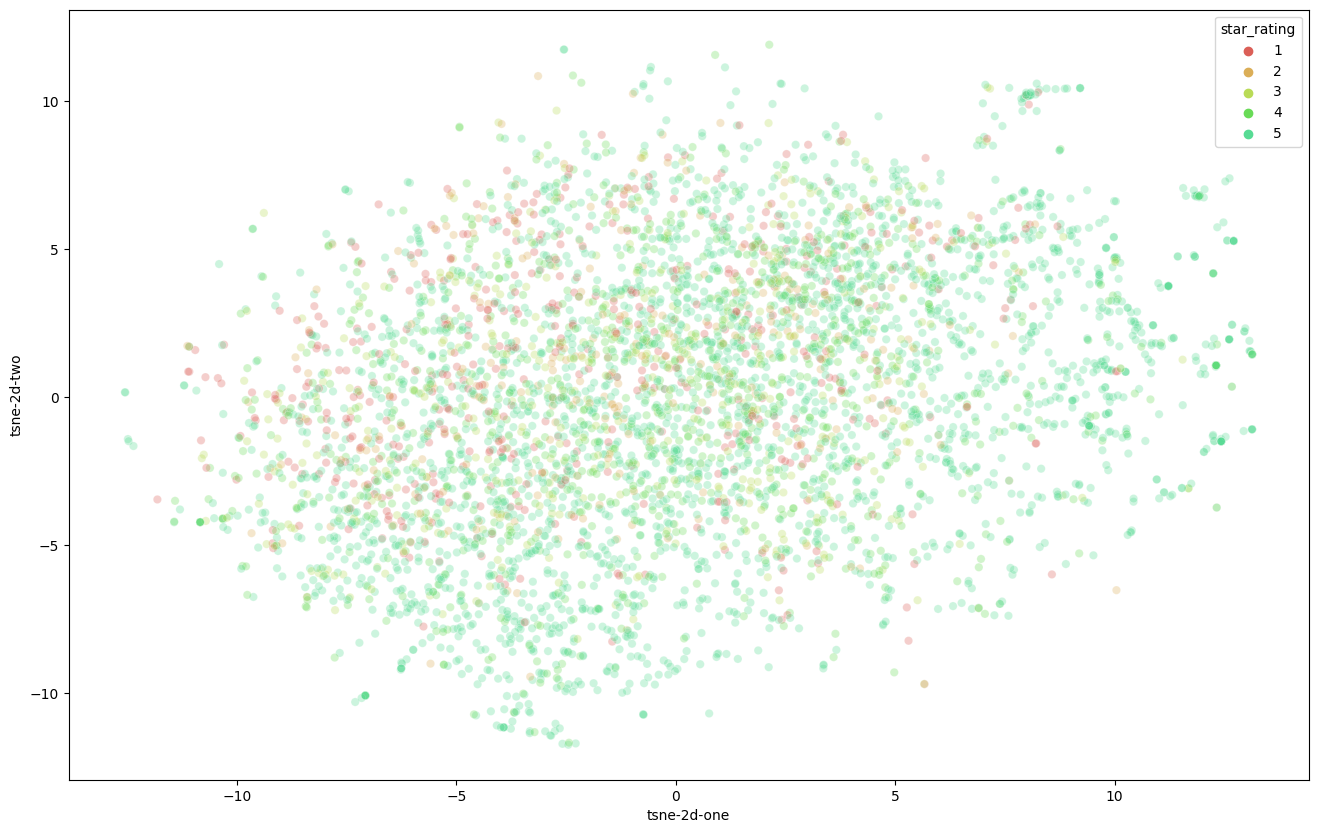

In [139]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="star_rating",
    palette=sns.color_palette("hls", 10),
    data=df_tsne_2_dim,
    legend="full",
    alpha=0.3
)

In [141]:
df_tsne_3_dim = pd.DataFrame([tsne_results[:,0].tolist(),
                              tsne_results[:,1].tolist(),
                              tsne_results[:,2].tolist()]).T
df_tsne_3_dim = df_tsne_3_dim.set_index(df.index)
df_tsne_3_dim.columns = ['tsne-3d-one', 'tsne-3d-two', 'tsne-3d-three']
df_tsne_3_dim['star_rating'] = df['star_rating']
df_tsne_3_dim

,tsne-3d-one,tsne-3d-two,tsne-3d-three,star_rating
1660627,1.078771,2.858945,-2.818633,5
1232608,-3.730477,-0.137178,0.907836,3
508804,8.297414,4.627144,-2.277590,5
1419576,-7.714201,-2.492566,1.956396,5
567632,1.305092,7.158868,-1.046704,5
...,...,...,...,...
380606,5.538782,-2.100430,-4.214038,5
73964,6.542043,4.057631,3.559041,5
1421630,4.702732,3.107298,0.098956,5
1646419,4.663186,5.040589,3.763834,3


In [151]:
import plotly.express as px
fig = px.scatter_3d(df_tsne_3_dim, x='tsne-3d-one', y='tsne-3d-two', z='tsne-3d-three', color='star_rating', width=1000, height=500)
fig.update_traces(marker_size = 3)
fig.show()

# Topic modeling

In [ ]:
# Remove punctuation
df['review_body_preprocessed'] = df['review_body'].apply(lambda x: re.sub(r"[,\.!?]", '', x))
# Convert the titles to lowercase
df['review_body_preprocessed'] = df['review_body'].apply(lambda x: x.lower())

In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data = df.review_body.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

['really', 'checked', 'earlier', 'later', 'due', 'system', 'requirements', 'high', 'versions', 'ea', 'sport', 'nhl', 'games', 'pc', 'quite', 'nicely', 'long', 'time', 'even', 'get', 'faster', 'better', 'computer', 'someday', 'pentium', 'iii', 'mhz', 'hard', 'drive', 'ram']


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 2), (2, 2), (3, 2), (4, 1), (5, 1), (6, 3), (7, 2), (8, 2), (9, 1), (10, 1), (11, 2), (12, 1), (13, 2), (14, 1), (15, 8), (16, 6), (17, 1), (18, 1), (19, 2), (20, 2), (21, 2), (22, 1), (23, 2), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 2)]


In [ ]:
# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                    id2word=id2word,
                                    num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.027*"game" + 0.011*"like" + 0.010*"br" + 0.010*"great" + 0.007*"would" + '
  '0.006*"good" + 0.006*"get" + 0.006*"got" + 0.005*"one" + 0.005*"games"'),
 (1,
  '0.024*"br" + 0.020*"game" + 0.010*"like" + 0.009*"one" + 0.008*"games" + '
  '0.007*"get" + 0.006*"good" + 0.006*"time" + 0.006*"really" + 0.005*"much"'),
 (2,
  '0.037*"game" + 0.008*"one" + 0.008*"really" + 0.007*"playing" + '
  '0.006*"games" + 0.006*"br" + 0.006*"get" + 0.005*"good" + '
  '0.005*"controller" + 0.005*"work"'),
 (3,
  '0.054*"game" + 0.013*"like" + 0.010*"br" + 0.010*"play" + 0.009*"get" + '
  '0.009*"one" + 0.008*"fun" + 0.008*"great" + 0.007*"good" + 0.007*"time"'),
 (4,
  '0.016*"br" + 0.009*"one" + 0.009*"game" + 0.007*"would" + 0.006*"great" + '
  '0.006*"like" + 0.006*"games" + 0.006*"well" + 0.006*"xbox" + 0.006*"still"'),
 (5,
  '0.044*"game" + 0.019*"br" + 0.012*"play" + 0.011*"games" + 0.010*"great" + '
  '0.009*"one" + 0.008*"fun" + 0.007*"get" + 0.006*"would" + 0.006*"much"'),
 (6,
  '0.0

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('../topic_modeling/ldavis_prepared_'+str(num_topics))

# if you want to execute visualization prep yourself

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, '../topic_modeling/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.032420  0.007145       1        1  22.691237
9     -0.024457 -0.001444       2        1  13.800176
8     -0.006931 -0.033025       3        1  13.349594
5     -0.017449 -0.000167       4        1  11.941899
1     -0.011945 -0.014334       5        1  10.430641
4      0.035410 -0.009594       6        1   8.088935
6      0.042847 -0.002102       7        1   7.235023
7      0.005981  0.019589       8        1   5.235070
0      0.007814  0.010043       9        1   4.158005
2      0.001149  0.023889      10        1   3.069420, topic_info=           Term           Freq          Total Category  logprob  loglift
15           br  116088.000000  116088.000000  Default  30.0000  30.0000
64         game  160897.000000  160897.000000  Default  29.0000  29.0000
29   controller   12647.000000   12647.000000  Default  28.0000  28.0000
74        great   34697.000000   34697.000000  Default  27.0000  27.0000
119         one   40642.000000   40642.000000  Default  26.0000  26.0000
..          ...            ...            ...      ...      ...      ...
96         love     466.125917   13385.624603  Topic10  -5.7838   0.1262
15           br     867.354194  116088.573049  Topic10  -5.1628  -1.4130
336         fun     542.839076   25720.561988  Topic10  -5.6315  -0.3746
186        time     480.465402   27104.130845  Topic10  -5.7535  -0.5490
16          buy     458.103812   14338.755492  Topic10  -5.8012   0.0401

[921 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
26546      2  0.038299   aaaa
26546      6  0.919165   aaaa
26546      9  0.038299   aaaa
26547      6  0.857474  aaaaa
1302       1  0.145438   able
...      ...       ...    ...
3205       6  0.061068  zumba
3205       7  0.023264  zumba
3205       8  0.308250  zumba
3205       9  0.029080  zumba
3205      10  0.002908  zumba

[3053 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 10, 9, 6, 2, 5, 7, 8, 1, 3])